In [37]:
from ipywidgets import IntSlider
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [38]:
import pandas as pd
import scipy
import shap
import numpy as np
import ZCA as zca
import statsmodels.api as sm
import matplotlib as plt

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import sklearn
from sklearn.preprocessing import *
from sklearn import preprocessing
import matplotlib.pyplot as plt

import IPython

from numpy import mean
from numpy import arange
from numpy import std
from numpy import absolute
from pandas import read_csv
import matplotlib.pyplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from sklearn.linear_model import ElasticNet
import seaborn as sns
from ModelDiagnostics import Plot
from sklearn.cluster import DBSCAN
from clustergram import Clustergram
import urbangrammar_graphics as ugg
from sklearn.preprocessing import scale
from scipy import stats
from scipy.special import boxcox, inv_boxcox

In [39]:
#power = PowerTransformer(method='box-cox')

def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    return inv_boxcox(data, lambdas.values)
    
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.boxcox((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def revert_boxcox (data, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data.iloc[:,i]
        else:
            revert = pd.DataFrame(inv_boxcox(data.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data.columns
    return reverted


In [40]:

all_data = pd.read_csv('/mnt/distvol/combined_set.csv')
all_data.index = all_data.iloc[:,0]
all_data = all_data.iloc[:,1:]

adds = []

for i in all_data.columns:
    m = min(all_data[i])
    if m < 0:
        adds.append(abs(m)+.0000000001)
    else:
        adds.append(0)

t_all_data = pd.DataFrame()
for i in range(0,len(all_data.columns)):
    t_all_data = pd.concat([t_all_data,all_data.iloc[:,i]+adds[i]],axis=1)
    
transformed, lambdas = transform_boxcox(t_all_data)

The null hypothesis cannot be rejected
The null hypothesis can be rejected
0.045615090503273795
The null hypothesis can be rejected
0.0445589035140191
The null hypothesis can be rejected
0.041234763491380104
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
0.3620609631528717
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
0.2715494429921067
The null hypothesis can be rejected
-1.1920353314826742
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
0.9575431643207697
The null hypothesis can be rejected
0.04453246453632214
The null hypothesis can be rejected
0.04332953524617733
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis can be rejected
-0.680288118255002
The null hypothesis can be rejected
-1.1449532736543295
The null hypothesis can be rejected


In [41]:
filter_ = all_data.columns.tolist()

In [42]:
output_slider_variable = widgets.Text()

def f2(x):    
    output_slider_variable.value = str(x)
    
def f3(x):
    Y = output_slider_variable.value    
    internalFilter = filter_
    internalFilter.remove(Y)
    all_data_ = pd.concat([all_data[Y],all_data[internalFilter]], axis=1)    
    print(all_data_.describe())
    
output_slider_variable.observe(f3, 'value')

print("choose Y")
interact(f2, x=filter_);

#dir(output_text.widget.out)

choose Y


interactive(children=(Dropdown(description='x', options=('DGS10', 'DTB3', 'DGS3MO', 'MORTGAGE30US', 'DFII10', …

In [43]:
Y = output_slider_variable.value 

In [44]:
cbd = True
ic = True

# evaluate an elastic net model on the dataset
tsize = .20
train, test = train_test_split(transformed.iloc[:,0:], test_size=tsize, shuffle=True)

interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=ic)

#train_t, lambdas_t = transform_boxcox(train)

#disabled boxcox
if cbd:
    train_t = train

scaler = preprocessing.StandardScaler().fit(train_t)

#
train_s = pd.DataFrame(scaler.transform(train_t))
train_s.columns = train.columns
train_s.index = train.index  

train_t = train_s

#test_t = transform_boxcox_l(test, lambdas_t)

#disabled boxcox
if cbd:
    test_t = test

test_s = pd.DataFrame(scaler.transform(test_t))
test_s.columns = test.columns
test_s.index = test.index

test_t = test_s

y_train = pd.DataFrame(train_t.iloc[:,0])

#exclude y

X_inter_train = pd.DataFrame(interaction.fit_transform(train_t.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_t.iloc[:,1:]).columns))

    #apply ZCA each time a set of factors are removed (i.e. iteratively)
 #trf = zca.ZCA().fit(X_inter_train)
  #trf = zca.ZCA().fit(X_train)

 #X_train = pd.DataFrame(trf.transform(X_inter_train))
  #X_train = pd.DataFrame(trf.transform(X_train))
 #X_train.columns=X_inter_train.columns
  #X_train.columns=X_train.columns
  #X_train.index = train.index

#X_inter_alt = X_train.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
#print(X_inter_alt.head(3))

y_test = pd.DataFrame(test_t.iloc[:,0])

X_inter_test = pd.DataFrame(interaction.fit_transform(test_t.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(test_t.iloc[:,1:]).columns))

 #X_test = pd.DataFrame(trf.transform(X_inter_test))
  #X_test = pd.DataFrame(trf.transform(X_test))

 #X_test.columns=X_inter_test.columns
  #X_test.columns=X_test.columns
  #X_test.index = test.index

#X_inter_t_alt = X_test.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
#X_inter_t_alt.head()


In [45]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

 #model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=4, verbose=0, precompute='auto')

model = ElasticNet()
grid = dict()
# fit model

grid['alpha'] = alphas
grid['l1_ratio'] = ratios

search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

 #results = search.fit(X_inter_train, y_train)
#results = search.fit(X_train, y_train)

results = search.fit(X_inter_train, y_train)

 #model.fit(X_inter_train, y_train)
# summarize chosen configuration

print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

print(results.best_estimator_)
best_model = ElasticNet(alpha=results.best_estimator_.alpha, l1_ratio = results.best_estimator_.l1_ratio)

#pd.concat([all_data[Y],all_data_int],axis=1)



MAE: -0.019
Config: {'alpha': 0.001, 'l1_ratio': 0.99}
ElasticNet(alpha=0.001, l1_ratio=0.99)


In [46]:
best_model.fit(X_inter_train,train_t.iloc[:,0])

trainScore = best_model.score(X_inter_train, y_train, sample_weight=None)
testScore = best_model.score(X_inter_test, y_test, sample_weight=None)
print(trainScore)
print(testScore)


0.9999313081126946
0.9997196628470993


No handles with labels found to put in legend.


Outlier threshold's
Cooks distance: > .5 to 1 
Leverage: > 0.7605633802816901 to 1.1408450704225352
Studentized residuals: > 3

cooks       9.314484
leverage    0.858545
tsres      -6.555193
Name: 2008-12-31, dtype: float64

cooks       3.434211
leverage    0.821555
tsres       4.570107
Name: 2009-03-31, dtype: float64

cooks       11.210286
leverage     0.993689
tsres        1.411899
Name: 2020-06-30, dtype: float64

cooks       0.337099
leverage    0.951564
tsres       0.693140
Name: 2021-03-31, dtype: float64



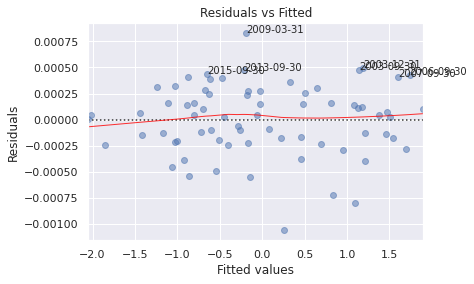

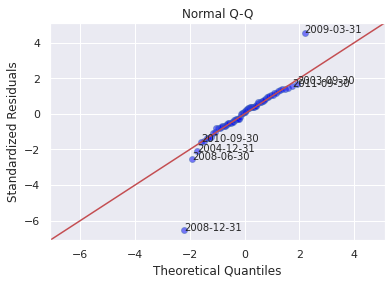

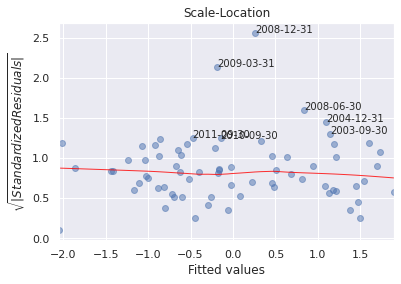

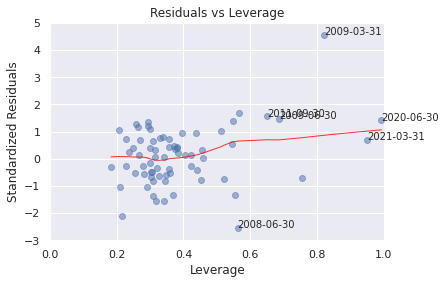

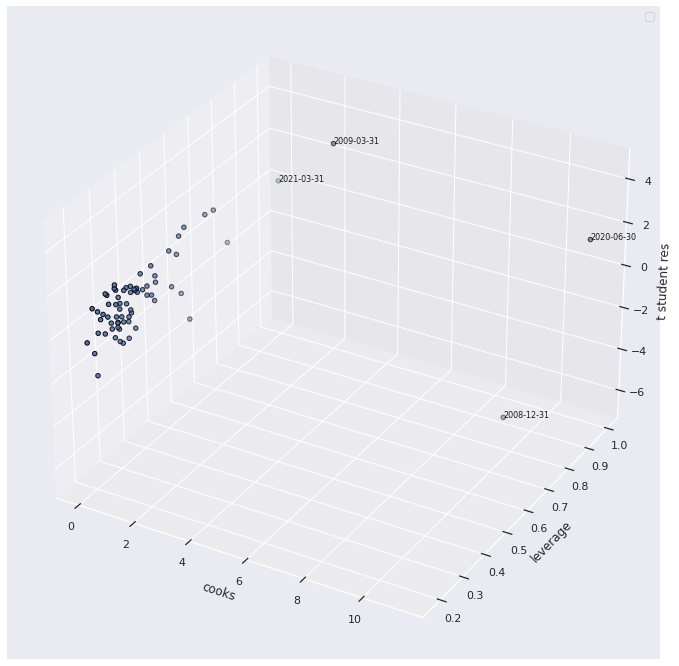

Outlier threshold's
Cooks distance: > .5 to 1 
Leverage: > 0.7605633802816901 to 1.1408450704225352
Studentized residuals: > 3
Summary of Regression
:                            OLS Regression Results                            
Dep. Variable:                  DGS10   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.410e+07
Date:                Sat, 15 May 2021   Prob (F-statistic):          3.15e-141
Time:                        18:45:53   Log-Likelihood:                 467.12
No. Observations:                  71   AIC:                            -878.2
Df Residuals:                      43   BIC:                            -814.9
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t    

<Figure size 432x288 with 0 Axes>

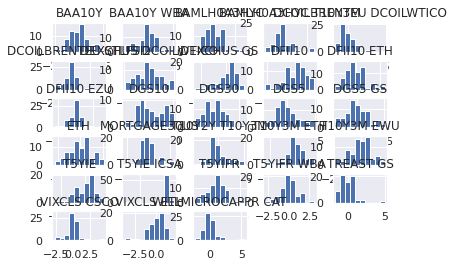

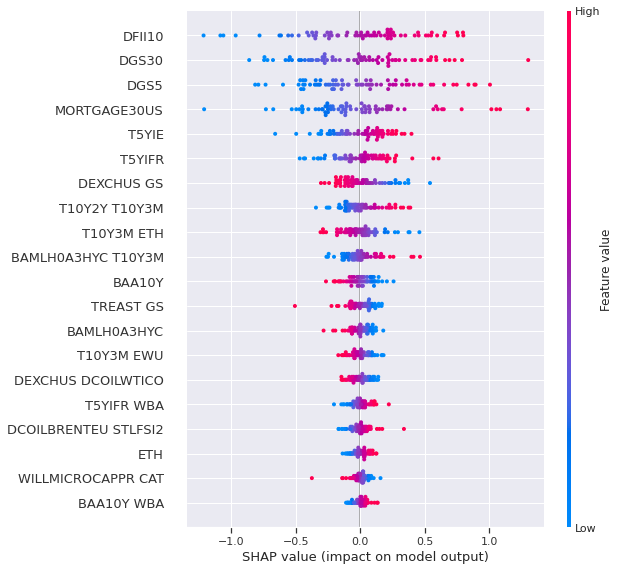

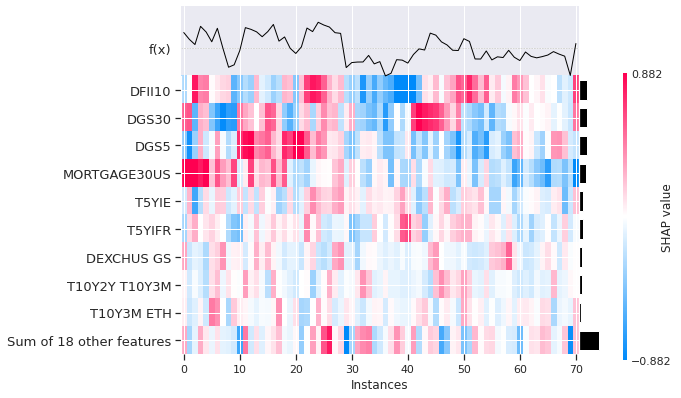

In [47]:
coef = pd.DataFrame(best_model.coef_).set_index(X_inter_train.columns)

a_coef = abs(coef)
a_coef.sort_values(by=[0],ascending=False,inplace=True)
chosen_few = a_coef[a_coef>0].dropna().index.values

scaler_ = preprocessing.StandardScaler().fit(all_data)

#
train_ = pd.DataFrame(scaler_.transform(all_data))
train_.columns = all_data.columns
train_.index = all_data.index  

X_inter_train_ = pd.DataFrame(interaction.fit_transform(train_.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_.iloc[:,1:]).columns))

max_pvalue = 1
New_Names = X_inter_train.columns
X_b = X_inter_train_[chosen_few]
while (max_pvalue > .05):
        
    trf = zca.ZCA().fit(X_b)
        
    X_b_z = pd.DataFrame(trf.transform(X_b))
    X_b_z.columns=pd.DataFrame(X_b).columns
    X_b_z.index = train_.index

    model_ = sm.OLS(train_.iloc[:,0],sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip'))        
    #model_ = sm.OLS(pd.DataFrame(pd.concat([train_.iloc[:,0],X_b_z],axis=1),sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip'))        
    results_ = model_.fit()

    set_ = X_b.columns.tolist()
    
    max_pvalue = max(results_.pvalues[1:])
    if (max_pvalue > .05):
        print(max_pvalue)
        max_pname = (results_.pvalues[1:]).idxmax(axis=1)
        set_.remove(max_pname)
        New_Names = set_
    
        X_b = X_inter_train_[New_Names]
        X_b.index = X_inter_train_.index

#from statsmodels.formula.api import ols
#lm = ols(pd.DataFrame(train_.iloc[:,0]) ~ sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip')).fit()
#table = sm.stats.anova_lm(model_, type=3)
#print(table)

linear_plot = Plot.LinearRegressionResidualPlot(X_b_z, pd.DataFrame(train_.iloc[:,0]))
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

plt.show()

%matplotlib inline

#sns.pairplot(pd.concat([pd.DataFrame(train[Y]),X_b_z],axis=1), hue=Y, height=2);

pd.concat([pd.DataFrame(train[Y]),X_b_z],axis=1).hist()

plt.show()

model_s = sklearn.linear_model.LinearRegression()
model_s.fit(X_b_z, pd.DataFrame(train_[Y]))

shap.initjs()
e = shap.explainers.Linear(model_s, X_b_z)

shap_values = e.shap_values(X_b_z)
shap.summary_plot(shap_values, X_b_z)
shap.plots.heatmap(e(X_b_z))